In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import xarray as xr

In [2]:
def levelset_reinit(phi, dx, dy, n_iter=50):
    """Concise PDE-based level set reinitialization"""
    phi0, dt = phi.copy(), 0.2 * min(dx, dy)
    eps = 1.5 * max(dx, dy)
    
    for _ in range(n_iter):
        # Forward/backward differences
        dxp = np.diff(phi, axis=0, append=phi[-1:]) / dx
        dxm = np.diff(phi, axis=0, prepend=phi[:1]) / dx  
        dyp = np.diff(phi, axis=1, append=phi[:, -1:]) / dy
        dym = np.diff(phi, axis=1, prepend=phi[:, :1]) / dy
        
        # Godunov upwind
        sign = phi0 / np.sqrt(phi0**2 + eps**2)
        grad_x = np.where(sign > 0, np.maximum(dxm, 0)**2 + np.minimum(dxp, 0)**2,
                                    np.maximum(dxp, 0)**2 + np.minimum(dxm, 0)**2)
        grad_y = np.where(sign > 0, np.maximum(dym, 0)**2 + np.minimum(dyp, 0)**2,
                                    np.maximum(dyp, 0)**2 + np.minimum(dym, 0)**2)
        
        # Update
        phi -= dt * sign * (np.sqrt(grad_x + grad_y) - 1)
    
    return phi

In [3]:
u_h5 = xr.open_dataset("u_ctr.xy.cross.00.h5", decode_times=False)
v_h5 = xr.open_dataset("v_ctr.xy.cross.00.h5", decode_times=False)

In [4]:
dx, dy = 12.5, 12.5
xsize, ysize = 6400, 3200

x = np.arange(dx/2, xsize, dx) - xsize/4
y = np.arange(dy/2, ysize, dy) - ysize/2

In [5]:
psi = np.zeros((len(y), len(x)))

# R = 200.0
# psi[:, :] = (x[None, :]**2 + y[:, None]**2)**.5 - R # Level set function for circle with radius 200

p = 2.0 # 2.0 is circle, inf is square
a_x, a_y = 50, 50
psi[:, :] = (np.abs(x[None, :]/a_x)**p + np.abs(y[:, None]/a_y)**p)**(1.0/p) - 1.0

F = np.ones_like(psi)
dFdt = np.zeros_like(psi)
alpha_F = - 1.0 / 200.0 # 1 / efolding time

H = np.zeros_like(psi)
rf = np.zeros_like(psi)
U = np.zeros_like(psi)

ros = 0.018 # heavy fuel, dry grass
u = 5.0 * np.ones_like(psi)
v = 0.0 * np.ones_like(psi)

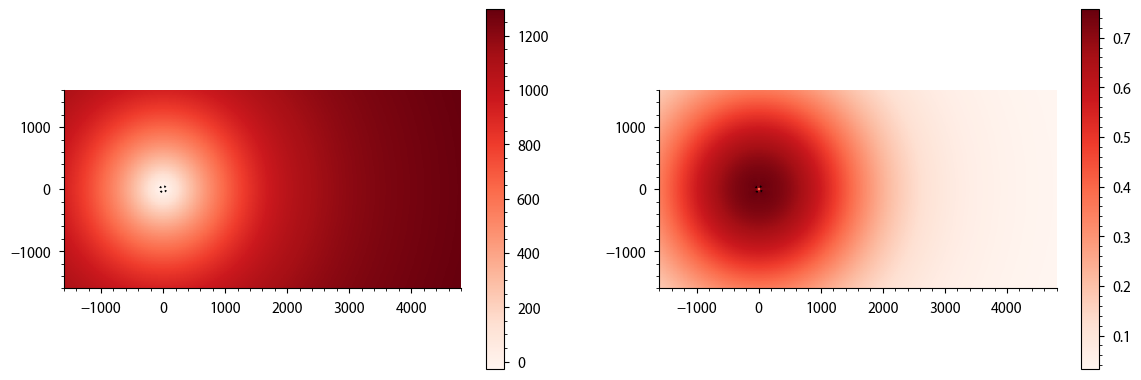

In [6]:
psi = levelset_reinit(psi, dx, dy, 500)
psi_0 = psi.copy()

grad_psi_x, grad_psi_y = np.gradient(psi, dx, axis=1), np.gradient(psi, dy, axis=0)
grad_psi = np.hypot(grad_psi_x, grad_psi_y)

plt.figure(figsize=(14, 4.5))

plt.subplot(121)
plt.gca().set_aspect("equal")
plt.pcolormesh(x, y, psi, cmap=plt.cm.Reds)
plt.colorbar()
plt.contour(x, y, psi, [-1e9, 0, 1e9], colors="k", linestyles=":")

plt.subplot(122)
plt.gca().set_aspect("equal")
plt.pcolormesh(x, y, grad_psi, cmap=plt.cm.Reds)
plt.colorbar()
plt.contour(x, y, psi, [-1e9, 0, 1e9], colors="k", linestyles=":")

In [7]:
time = 0.0
dt = 3.0
total_time = 2100
dt_output = 15.0

n_output = round(total_time / dt_output) + 1
dF_dt_out = np.zeros((n_output, *psi.shape))
psi_out = np.zeros((n_output, *psi.shape))
n_step = round(dt_output / dt)

rothermel_spread = 0.0

n = 0
while time <= total_time:
    grad_psi_x, grad_psi_y = np.gradient(psi, dx, axis=1), np.gradient(psi, dy, axis=0)
    grad_psi = np.hypot(grad_psi_x, grad_psi_y)

    u_norm = grad_psi_x / grad_psi
    v_norm = grad_psi_y / grad_psi

    eps = 0.1
    lapl_psi = np.zeros_like(psi)
    lapl_psi[1:-1, 1:-1] = (
          (psi[1:-1, :-2] - 2*psi[1:-1, 1:-1] + psi[1:-1, 2:]) / dx 
        + (psi[:-2, 1:-1] - 2*psi[1:-1, 1:-1] + psi[2:, 1:-1]) / dy
    )

    u = u_h5["u_ctr"].sel(time=time+1500, method="nearest").values[0, :, :]
    v = v_h5["v_ctr"].sel(time=time+1500, method="nearest").values[0, :, :]

    # u[:, :] = u.mean()
    # v[:, :] = v.mean()
    
    U = np.maximum(0.0, u * u_norm + v * v_norm)

    # Here I work towards the WRF level set paper.
    B = 1.0
    C = (1.701 / ros - 1) / 5
    
    phi_w = C * U ** B
    rf = ros * (1.0 + phi_w)
    
    dpsi_dt = - rf * (grad_psi - eps * lapl_psi)

    dF_dt = np.where(psi < 0.0, alpha_F * F, 0.0)

    # Store output.
    if n % n_step == 0:
        i = n // n_step
        dF_dt_out[i, :, :] = dF_dt[:, :]
        psi_out[i, :, :] = psi[:, :]

    # Integrate in time.
    F += dt * dF_dt
    psi += dt * dpsi_dt

    n += 1    
    time += dt

    psi = levelset_reinit(psi, dx, dy, 3)

In [8]:
Mf = 0.07 # Mass fraction of water
wl = 1.9 # kg/m2
h = 18.16e6 # J/kg
Lv = 2.5e6 # J/kg

H_out = - dF_dt_out * 1.0 / (1.0 + Mf) * wl * h
LE_out = - dF_dt_out * (Mf + 0.56) / (1.0 + Mf) * wl * Lv

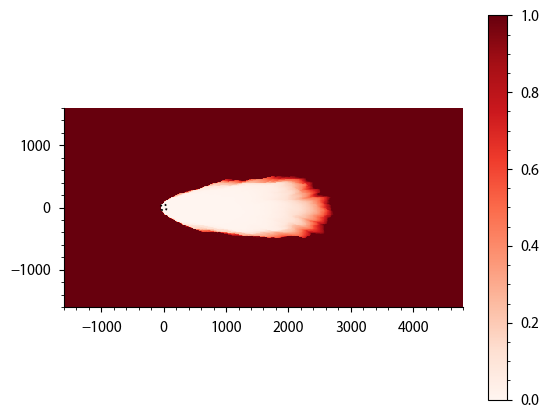

In [9]:
plt.figure()
plt.gca().set_aspect("equal")
plt.pcolormesh(x, y, F, cmap=plt.cm.Reds, vmin=0, vmax=1)
plt.colorbar()
plt.contour(x, y, psi_0, [-1e9, 0, 1e9], colors="k", linestyles=":")
# plt.plot( [1.701*35*60, 1.701*35*60], [-500, 500], 'w:')

Text(0, 0.5, 'y (m)')

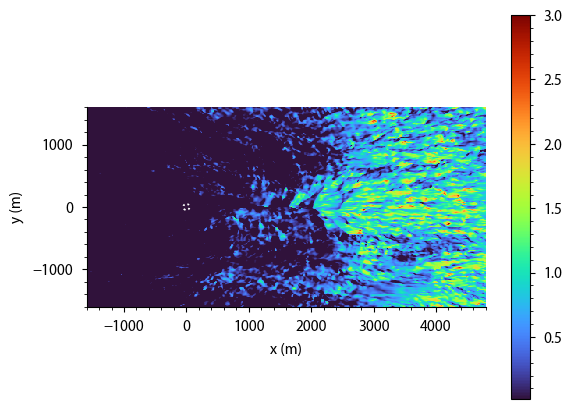

In [10]:
plt.figure()
plt.gca().set_aspect("equal")
plt.pcolormesh(x, y, rf, cmap=plt.cm.turbo)
plt.colorbar()
plt.contour(x, y, psi_0, [-1e9, 0, 1e9], colors="w", linestyles=":")
plt.xlabel('x (m)')
plt.ylabel('y (m)')

In [17]:
fig, ax = plt.subplots(figsize=(10.2, 4))
ax.set_aspect("equal")
fuel_use = ax.pcolormesh(x, y, H_out[0, :, :], cmap=plt.cm.turbo, vmin=0, vmax=H_out.max())
plt.colorbar(fuel_use)
ax.contour(x, y, psi_0, [-1e9, 0, 1e9], colors="w", linestyles=":")
# ax.plot( [1.701*35*60, 1.701*35*60], [-500, 500], 'w:')
plt.close()

def animate(i):
    fuel_use.set_array(H_out[i, :, :])
    return [fuel_use]

# Call the animator. Keyword blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=psi_out.shape[0], interval=20, blit=True)

anim.save("heat_flux.mp4", writer="ffmpeg", fps=50)
HTML(anim.to_jshtml())

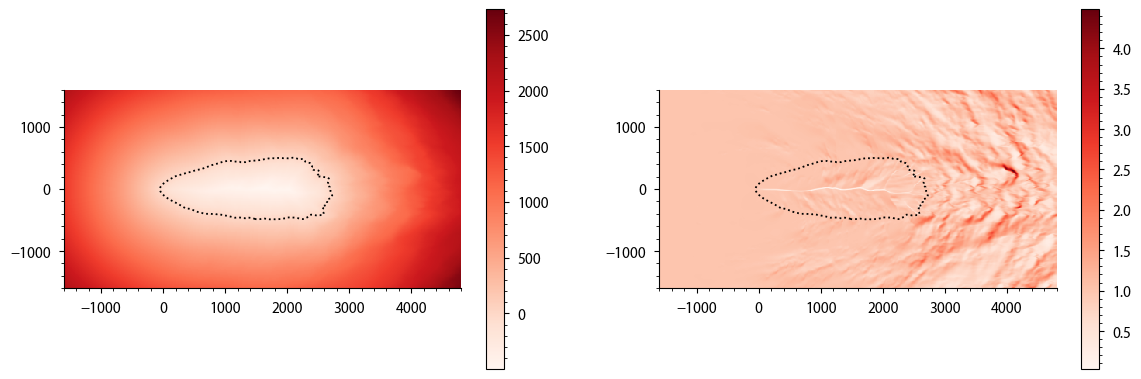

In [12]:
grad_psi_x, grad_psi_y = np.gradient(psi, dx, axis=1), np.gradient(psi, dy, axis=0)
grad_psi = np.hypot(grad_psi_x, grad_psi_y)

plt.figure(figsize=(14, 4.5))

plt.subplot(121)
plt.gca().set_aspect("equal")
plt.pcolormesh(x, y, psi, cmap=plt.cm.Reds)
plt.colorbar()
plt.contour(x, y, psi, [-1e9, 0, 1e9], colors="k", linestyles=":")

plt.subplot(122)
plt.gca().set_aspect("equal")
plt.pcolormesh(x, y, grad_psi, cmap=plt.cm.Reds)
plt.colorbar()
plt.contour(x, y, psi, [-1e9, 0, 1e9], colors="k", linestyles=":")